# Toy example of training a CNN to detect deletions

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as datautils
import seaborn as sb
from beakerx.object import *
beakerx.pandas_display_default()

%matplotlib widget

In [59]:
from dataclasses import dataclass # python 3.6

# Basic parameters for the simulation
data_len = 220

deletion_size = 20
deletion_std_dev = 0.1
num_positive_training_samples = 100

num_controls = 100
control_std_dev = 0.1

# A simple class to capture the data about a "true positive" training
# sample
@dataclass
class Sample:
  sample_id : str
  covs : np.ndarray
  tp_start: int
  contains_deletion : bool
  

def create_positive_sample(sample_id : str):
  """
  Creates a positive sample by selecting a random offset within 
  the data and creating a region of 0.5 coverage values within it
  """

  # select a random offset for the 20 bp deletion
  offset = int(np.random.uniform(deletion_size, data_len - deletion_size*2))
  
  values =  np.concatenate(
      (np.random.normal(1, deletion_std_dev, offset), 
      np.random.normal(0.5, deletion_std_dev, deletion_size),
      np.random.normal(1, deletion_std_dev, data_len-offset-deletion_size))
  )
  
  return Sample(sample_id=sample_id, covs=np.array(values, dtype=np.dtype('d')), tp_start=offset, contains_deletion=True)

# Create the training data

In [60]:
positive_samples = [
    create_positive_sample('positive_%s' % (sample_id+1))
    for sample_id in range(0, num_positive_training_samples)
]

test_positive_samples = [
    create_positive_sample('positive_%s' % (sample_id+1))
    for sample_id in range(0, num_positive_training_samples)
]


In [61]:
plt.close()

for positive_sample in positive_samples[0:10]:
  plt.plot(positive_sample.covs)

plt.ylim((0,2))
plt.title('Signal of simulated positive training samples')
plt.xlabel('Position in Simulated Chromosome')
plt.ylabel('Value of Simulated Coverage Depth')
None

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Create Training Data for Controls

Here by "control" we mean a sample that is negative ie: there are no deletions present in the data. We will label these "0" as a class that has no deletion to detect.

In [62]:
def create_control_sample(sample_id):
  values = np.random.normal(1,control_std_dev,data_len)
  return Sample(sample_id=sample_id, covs=values, tp_start=-1, contains_deletion=False)

control_samples =  [create_control_sample(f"control_${c}") for c in range(0,num_controls)]

test_control_samples =  [create_control_sample(f"control_${c}") for c in range(0,num_controls)]

In [63]:
plt.close()

for c in control_samples[0:10]:
  plt.plot(c.covs)

plt.title('Coverage Values for Simulated Negative Training Samples')
plt.xlabel('Position in Simulated Chromosome')
plt.ylabel('Value of Simulated Coverage Depth')
plt.ylim(0,2.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 2.0)

## Create the CNN

In [64]:
import torch.nn as nn
import torch.nn.functional as F

In [65]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

In [66]:
running_loss = 0.0

In [67]:
ps = positive_samples[0]

In [68]:
pos_data = torch.tensor([[ps.covs for ps in positive_samples]])

In [69]:
pos_data[0]

tensor([[1.1884, 0.9542, 0.9708,  ..., 0.9733, 0.9947, 0.9884],
        [0.9434, 0.9651, 1.0453,  ..., 0.9439, 1.0339, 0.9242],
        [0.9895, 1.0148, 1.0437,  ..., 1.0616, 1.0467, 1.0177],
        ...,
        [0.9322, 1.1644, 0.9969,  ..., 1.1486, 1.0218, 0.8946],
        [0.9621, 1.0403, 0.9457,  ..., 0.7916, 1.0469, 1.2135],
        [0.9291, 1.1298, 0.9476,  ..., 1.1604, 1.2446, 1.1558]],
       dtype=torch.float64)

In [70]:
class CNVDataSet(datautils.Dataset):
    
    def __init__(self,samples):
        self.samples = [torch.tensor([s.covs], dtype=torch.double) for s in samples]
        self.labels = [torch.tensor(1) if s.contains_deletion else torch.tensor(0) for s in samples ]
    
    def __getitem__(self,index):
        return (self.samples[index], self.labels[index])

    def __len__(self):
        return len(self.samples)
    
    def __repr__(self):
        return f"{len(self.samples)} samples containing {sum(self.labels)} true positives"
        

# positive_dataset = d.TensorDataset(*[torch.tensor(ps.covs) for ps in positive_samples])
# positive_dataset = datautils.TensorDataset(pos_data)

positive_dataset = CNVDataSet(positive_samples)

test_positive_dataset = CNVDataSet(test_positive_samples)

control_dataset = CNVDataSet(control_samples)

test_control_dataset = CNVDataSet(test_control_samples)


combined_dataset = CNVDataSet(positive_samples + control_samples)


In [71]:
combined_dataset

200 samples containing 100 true positives

In [72]:



training_loader = datautils.DataLoader(combined_dataset, batch_size=1, shuffle=True, num_workers=0)

In [73]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 5)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 4, 6)
        self.fc1 = nn.Linear(204, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        
        x1 = self.conv1(x)
        
        x2 = F.relu(x1)
        
        x3 = self.pool(x2)
        
        x4 = self.conv2(x3)
        
        x5 = self.pool(F.relu(x4))
        
#         print(x5.size())
        
        x = x5.view(-1, x5.size()[0] * x5.size()[1] * x5.size()[2])
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [74]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net = net.double()

for epoch in range(100):
    
    running_loss = 0.0
    
    for i, data in enumerate(training_loader, 0):
            optimizer.zero_grad()

            inputs,labels = data
#             if i == 0:
#                 print(inputs)

#             print(labels)
                
            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            
            running_loss += loss.item()

            optimizer.step()
            
    print("Total loss = %.3f" % running_loss)

print("Done") 

Total loss = 139.456
Total loss = 139.321
Total loss = 138.744
Total loss = 139.190
Total loss = 138.838
Total loss = 138.956
Total loss = 138.827
Total loss = 137.869
Total loss = 139.445
Total loss = 138.497
Total loss = 139.175
Total loss = 138.551
Total loss = 137.942
Total loss = 137.935
Total loss = 136.761
Total loss = 137.955
Total loss = 136.718
Total loss = 134.524
Total loss = 131.580
Total loss = 128.514
Total loss = 122.648
Total loss = 108.833
Total loss = 59.053
Total loss = 36.309
Total loss = 21.889
Total loss = 51.090
Total loss = 16.330
Total loss = 8.606
Total loss = 5.481
Total loss = 3.934
Total loss = 2.980
Total loss = 2.390
Total loss = 1.974
Total loss = 1.672
Total loss = 1.444
Total loss = 1.266
Total loss = 1.125
Total loss = 1.007
Total loss = 0.912
Total loss = 0.830
Total loss = 0.760
Total loss = 0.702
Total loss = 0.652
Total loss = 0.606
Total loss = 0.567
Total loss = 0.532
Total loss = 0.501
Total loss = 0.473
Total loss = 0.447
Total loss = 0.425
T

In [75]:
outputs

tensor([[-4.3952,  3.8138]], dtype=torch.float64, grad_fn=<AddmmBackward>)

In [76]:
labels.dtype

torch.int64

In [118]:

def predict(data,index):
    
    test_data = data[index][0].view(-1,1,data[index][0].size()[1])

    return net(test_data).detach().numpy()[0]

def score(data,index):
    c = predict(data,index)
    return c[0] - c[1]
    
score(positive_dataset,0)

-9.117067137077548

In [127]:


test_positive_scores = [score(test_positive_dataset,i) for i in range(100)]
test_control_scores = [score(test_control_dataset,i) for i in range(100)]

plt.close()

sb.kdeplot(x=test_positive_scores, label='Positive Samples',shade=True)
ax = sb.kdeplot(x=test_control_scores, label='Control Samples',shade=True)
ax.set_title('Distribution of Scores Positive and Control Validation Test Samples')
ax.set_xlabel('CNN Score')
ax.legend()
ax.set_xlim(right=10.0)




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-12.52486872276476, 10.0)

In [105]:
x[0] - x[1]

tensor(-9.1171, dtype=torch.float64, grad_fn=<SubBackward0>)

In [85]:
positive_predictions = [predict(positive_dataset,i) for i in range(0,20)]
test_positive_predictions = [predict(test_positive_dataset,i) for i in range(0,20)]

In [86]:
control_predictions = [predict(control_dataset,i) for i in range(0,20)]
test_control_predictions = [predict(test_control_dataset,i) for i in range(0,20)]

In [87]:
plt.close()

sb.scatterplot(
    x=[pt.detach().numpy()[0][0] for pt in positive_predictions],
    y=[pt.detach().numpy()[0][1] for pt in positive_predictions],
    label='Training Deletion Samples'
)

sb.scatterplot(
    x=[pt.detach().numpy()[0][0] for pt in test_positive_predictions],
    y=[pt.detach().numpy()[0][1] for pt in test_positive_predictions],
    label='Test Deletion Samples'
)

sb.scatterplot(
    x=[pt.detach().numpy()[0][0] for pt in control_predictions],
    y=[pt.detach().numpy()[0][1] for pt in control_predictions],
    label='Training Negative Samples'
)

ax = sb.scatterplot(
    x=[pt.detach().numpy()[0][0] for pt in test_control_predictions],
    y=[pt.detach().numpy()[0][1] for pt in test_control_predictions],
    label='Test Negative Samples'
)

ax.set_title('Predictions from Training on Simulated Data')



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Predictions from Training on Simulated Data')

In [82]:
y = torch.tensor([4,5,6])

In [53]:
net.conv1.bias

Parameter containing:
tensor([ 0.1778, -0.3872,  0.3824,  0.2252,  0.1140,  0.3552,  0.2928,  0.1545],
       dtype=torch.float64, requires_grad=True)

In [28]:
x.sub(y)

tensor([-3, -3, -3])

In [83]:
kernels = net.conv2.weight.reshape(8,5)[0:2]

RuntimeError: shape '[8, 5]' is invalid for input of size 192

In [111]:
import seaborn as sb

<AxesSubplot:>

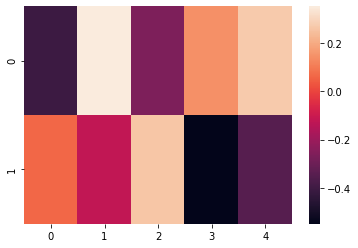

In [112]:
sb.heatmap(kernels.detach().numpy())

[[<matplotlib.lines.Line2D at 0x7fb1836e0990>],

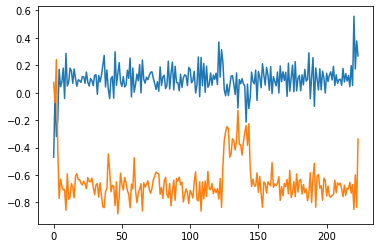

In [113]:
[ plt.plot(np.convolve(positive_samples[0].covs,k.detach().numpy())) for k in kernels ]

In [114]:
from beakerx import *

In [117]:
p = Plot()

for k in kernels:
    p.add(Line(y=np.convolve(positive_samples[0].covs,k.detach().numpy())))
           
p           

In [44]:
positive_samples[0].covs[0]

0.9986804165670898

In [43]:
help(np.convolve)

Help on function convolve in module numpy:

convolve(a, v, mode='full')
    Returns the discrete, linear convolution of two one-dimensional sequences.
    
    The convolution operator is often seen in signal processing, where it
    models the effect of a linear time-invariant system on a signal [1]_.  In
    probability theory, the sum of two independent random variables is
    distributed according to the convolution of their individual
    distributions.
    
    If `v` is longer than `a`, the arrays are swapped before computation.
    
    Parameters
    ----------
    a : (N,) array_like
        First one-dimensional input array.
    v : (M,) array_like
        Second one-dimensional input array.
    mode : {'full', 'valid', 'same'}, optional
        'full':
          By default, mode is 'full'.  This returns the convolution
          at each point of overlap, with an output shape of (N+M-1,). At
          the end-points of the convolution, the signals do not overlap
          co

In [33]:
help(nn.Conv1d)

Help on class Conv1d in module torch.nn.modules.conv:

class Conv1d(_ConvNd)
 |  Conv1d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int]], stride: Union[int, Tuple[int]] = 1, padding: Union[int, Tuple[int]] = 0, dilation: Union[int, Tuple[int]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros')
 |  
 |  Applies a 1D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, L)` and output :math:`(N, C_{\text{out}}, L_{\text{out}})` can be
 |  precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{\text{out}_j}, k)
 |      \star \text{input}(N_i, k)
 |  
 |  where :math:`\star` is the valid `cross-correlation`_ operator,
 |  :math:`N` is a batch size, :math:`C` denotes a number of channels,
 |  :math:`L` is a length

In [2]:
torch.cuda.current_device()

0